In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                   import metrics
from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics           import accuracy_score, mean_squared_error, confusion_matrix
from sklearn.linear_model      import LogisticRegression
from sklearn.pipeline          import Pipeline
from sklearn.naive_bayes       import MultinomialNB
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm               import SVC


import requests
import time

import warnings
warnings.filterwarnings("ignore")

#adjusting display to see more data for convenience
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('model_single_season.csv', index_col = 0)
df.head()

#We are going to create a testing dataframe from the original dataset. The testing dataframe will include all the players drafted in the 2019 draft. These players have yet to play in the NBA, therefore, could not have made an all-star game. 
#Our goal will be to predict the probability that these players make the game in their career.

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,FT_misses,new_FTM,new_FT_misses,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg
0,Charles Jenkins,Hofstra,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,4,75,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,8.13409,9.32934,-1.195250,8.301,37.4063,8.400,-0.099,0,720,22.50,0,0,0,1,0,0,0,0,1,38,250,69,0.785489,89,99,155,0.388889,141,226,193,0.539568
1,Richard Hendrix,Alabama,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,3,81,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,10.16180,5.61840,4.543410,9.197,30.6250,7.032,2.165,0,568,17.75,0,0,0,0,0,0,1,1,0,93,179,124,0.591362,5,38,71,0.345794,149,277,201,0.579832
2,Vernon Macklin,Florida,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,7.7,17.7,46,102,0.451,191,322,0.593,0,0,0.000,3.1,0.9,31.7,4,82,2.82126,118.954,4.0,2011,91,0.476185,52.0,97.7281,93.3167,2.78675,155.033,4.01017,2.54894,1.461230,4.129,24.4595,3.524,0.605,0,428,11.57,0,0,0,0,0,0,1,1,0,56,117,87,0.574257,0,36,66,0.350000,131,241,183,0.568720
3,Maarty Leunen,Oregon,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,15.5,14.1,112,142,0.789,98,161,0.609,59,120,0.492,1.1,1.5,50.5,4,81,6.62117,140.360,2.8,2008,94,1.800000,54.0,102.8660,97.1158,3.52963,222.794,11.15260,9.23392,1.918640,9.765,34.7188,8.596,1.169,0,485,15.16,0,0,0,0,1,0,0,1,0,30,183,61,0.752066,61,95,127,0.427273,63,148,115,0.563218
4,Malik Hairston,Oregon,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,14.0,14.3,101,138,0.732,124,215,0.577,52,120,0.433,2.9,1.2,41.2,4,78,5.33399,134.172,3.7,2008,98,1.199977,48.0,106.9630,100.4400,2.84072,164.953,7.53980,6.88089,0.658901,7.456,31.4839,7.095,0.361,0,505,16.29,0,0,0,0,1,0,0,0,1,37,172,68,0.718487,68,88,134,0.395455,91,174,143,0.549206


In [3]:
#creating testing set dataframe
test_df = df[df['year'] == 2019]

#removing 2019 from the original dataframe
df = df[df['year'] != 2019]

In [4]:
#creating column
df['player_index'] = df['player_name'] + ': ' + df['school'] + ': ' + df['pick'].astype(str)

#setting index
df.set_index(df['player_index'], inplace = True)

#dropping newly created columns
df.drop(columns = ['player_index'], inplace = True)

df.head()

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,FT_misses,new_FTM,new_FT_misses,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg
player_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Charles Jenkins: Hofstra: 44.0,Charles Jenkins,Hofstra,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,4,75,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,8.13409,9.32934,-1.195250,8.301,37.4063,8.400,-0.099,0,720,22.50,0,0,0,1,0,0,0,0,1,38,250,69,0.785489,89,99,155,0.388889,141,226,193,0.539568
Richard Hendrix: Alabama: 49.0,Richard Hendrix,Alabama,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,3,81,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,10.16180,5.61840,4.543410,9.197,30.6250,7.032,2.165,0,568,17.75,0,0,0,0,0,0,1,1,0,93,179,124,0.591362,5,38,71,0.345794,149,277,201,0.579832
Vernon Macklin: Florida: 52.0,Vernon Macklin,Florida,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,7.7,17.7,46,102,0.451,191,322,0.593,0,0,0.000,3.1,0.9,31.7,4,82,2.82126,118.954,4.0,2011,91,0.476185,52.0,97.7281,93.3167,2.78675,155.033,4.01017,2.54894,1.461230,4.129,24.4595,3.524,0.605,0,428,11.57,0,0,0,0,0,0,1,1,0,56,117,87,0.574257,0,36,66,0.350000,131,241,183,0.568720
Maarty Leunen: Oregon: 54.0,Maarty Leunen,Oregon,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,15.5,14.1,112,142,0.789,98,161,0.609,59,120,0.492,1.1,1.5,50.5,4,81,6.62117,140.360,2.8,2008,94,1.800000,54.0,102.8660,97.1158,3.52963,222.794,11.15260,9.23392,1.918640,9.765,34.7188,8.596,1.169,0,485,15.16,0,0,0,0,1,0,0,1,0,30,183,61,0.752066,61,95,127,0.427273,63,148,115,0.563218
Malik Hairston: Oregon: 48.0,Malik Hairston,Oregon,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,14.0,14.3,101,138,0.732,124,215,0.577,52,120,0.433,2.9,1.2,41.2,4,78,5.33399,134.172,3.7,2008,98,1.199977,48.0,106.9630,100.4400,2.84072,164.953,7.53980,6.88089,0.658901,7.456,31.4839,7.095,0.361,0,505,16.29,0,0,0,0,1,0,0,0,1,37,172,68,0.718487,68,88,134,0.395455,91,174,143,0.549206


In [5]:
df.columns

Index(['player_name', 'school', 'GP', 'Min_per', 'ORtg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'yr', 'ht', 'porpag', 'adjoe', 'pfr', 'year', 'pid', 'ast/tov', 'pick', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'all_star', 'total_points', 'PPG', 'conference_B10', 'conference_B12', 'conference_BE',
       'conference_Non_major', 'conference_P10', 'conference_P12', 'conference_SEC', 'Pos_F', 'Pos_G', 'FT_misses', 'new_FTM', 'new_FT_misses', 'new_FT_avg', '3P_misses', 'new_TPM', 'new_3P_misses', 'new_3P_avg', '2P_misses', 'new_2PM', 'new_2P_misses', 'new_2P_avg'],
      dtype='object')

In [6]:
#features to drop 
drop = ['player_name','school', 'year', 'pid', 'pick', 'all_star']

In [7]:
#setting X and y
features = df.drop(columns = drop).columns
X = df[features]
y = df['all_star']

In [8]:
#checking shapes 
print(X.shape)
y.shape

(530, 62)


(530,)

In [9]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [10]:
ss = StandardScaler()
ss.fit(X_train) 
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [11]:
lr = LogisticRegression()

lr_params = {
    'C': [.001, .01, 0.1, 0.5, 1, 5, 10],
    'penalty': ['l1', 'l2']
}

gs = GridSearchCV(lr, param_grid=lr_params, cv=3, verbose = 1)
gs_sc = GridSearchCV(lr, param_grid=lr_params, cv=3, verbose = 1)
gs.fit(X_train, y_train)
gs_sc.fit(X_train_sc, y_train)
print('Unscaled')
print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
print(gs.best_params_)
print('Scaled')
print(f'CrossVal Score: {gs_sc.best_score_}')
print(f'Training Score: {gs_sc.score(X_train_sc, y_train)}')
print(f'Testing Score: {gs_sc.score(X_test_sc, y_test)}')
print(gs_sc.best_params_)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Unscaled
CrossVal Score: 0.9471026049973418
Training Score: 0.9445843828715366
Testing Score: 0.9323308270676691
{'C': 0.001, 'penalty': 'l2'}
Scaled
CrossVal Score: 0.9445963393331814
Training Score: 0.9445843828715366
Testing Score: 0.9398496240601504
{'C': 0.001, 'penalty': 'l2'}


In [12]:
gs_sc.predict_proba(X_test)[:10]

array([[3.92993307e-02, 9.60700669e-01],
       [2.21272732e-03, 9.97787273e-01],
       [2.43638257e-02, 9.75636174e-01],
       [3.58404612e-04, 9.99641595e-01],
       [1.35695299e-04, 9.99864305e-01],
       [7.23320367e-03, 9.92766796e-01],
       [6.54905710e-04, 9.99345094e-01],
       [8.34821549e-04, 9.99165178e-01],
       [3.84746974e-04, 9.99615253e-01],
       [6.87878645e-01, 3.12121355e-01]])

In [13]:
gs_sc.predict_proba(X_test)[:10]

array([[3.92993307e-02, 9.60700669e-01],
       [2.21272732e-03, 9.97787273e-01],
       [2.43638257e-02, 9.75636174e-01],
       [3.58404612e-04, 9.99641595e-01],
       [1.35695299e-04, 9.99864305e-01],
       [7.23320367e-03, 9.92766796e-01],
       [6.54905710e-04, 9.99345094e-01],
       [8.34821549e-04, 9.99165178e-01],
       [3.84746974e-04, 9.99615253e-01],
       [6.87878645e-01, 3.12121355e-01]])

In [14]:
knn = KNeighborsClassifier()

knn_params = {'n_neighbors': [5, 10, 15],
              'weights': ['uniform', 'distance']
}

gs_sc = GridSearchCV(knn, param_grid=knn_params, cv=3, verbose = 1)
gs_sc.fit(X_train_sc, y_train)

print('Scaled')
print(f'CrossVal Score: {gs_sc.best_score_}')
print(f'Training Score: {gs_sc.score(X_train_sc, y_train)}')
print(f'Testing Score: {gs_sc.score(X_test_sc, y_test)}')
print(gs_sc.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Scaled
CrossVal Score: 0.9445963393331814
Training Score: 0.947103274559194
Testing Score: 0.9323308270676691
{'n_neighbors': 5, 'weights': 'uniform'}


In [15]:
1 - y_test.mean()

0.9398496240601504

In [16]:
gs_sc.predict_proba(X_test)[:10]

array([[0.8, 0.2],
       [0.8, 0.2],
       [0.8, 0.2],
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ]])

In [17]:
dt = DecisionTreeClassifier(random_state = 42)

dt_params = {}

gs = GridSearchCV(dt, param_grid=dt_params, cv=3, verbose = 1)

gs.fit(X_train, y_train)

print('Unscaled')
print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
print(gs.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Unscaled
CrossVal Score: 0.8790726817042606
Training Score: 1.0
Testing Score: 0.9097744360902256
{}


In [18]:
dt = DecisionTreeClassifier(random_state = 42)

dt_params = {'max_depth': [5,10, 15, 50],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [2, 3, 4]
}

gs = GridSearchCV(dt, param_grid=dt_params, cv=3, verbose = 1)

gs.fit(X_train, y_train)

print('Unscaled')
print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
print(gs.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Unscaled
CrossVal Score: 0.9269955191007823
Training Score: 0.964735516372796
Testing Score: 0.9398496240601504
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3}


In [19]:
gs.predict_proba(X_test)[:10]

array([[1.        , 0.        ],
       [0.85714286, 0.14285714],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [0.94736842, 0.05263158],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [0.94736842, 0.05263158],
       [0.94736842, 0.05263158],
       [1.        , 0.        ]])

In [20]:
rf = RandomForestClassifier(random_state = 42)

rf_params = {}

gs = GridSearchCV(rf, param_grid = rf_params, cv=3, verbose = 1)
gs.fit(X_train, y_train)

print('Unscaled')
print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
print(gs.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Unscaled
CrossVal Score: 0.9445963393331814
Training Score: 1.0
Testing Score: 0.9398496240601504
{}


In [43]:
rf = RandomForestClassifier(random_state = 42)

rf_params = {'n_estimators': [50, 60, 70],
             'max_depth': [None, 50],
             'min_samples_split': [2, 3, 5, 7],
             'min_samples_leaf': [1, 2, 3, 4]}

rf_gs = GridSearchCV(rf, param_grid=rf_params, cv=3, verbose = 1)
rf_gs.fit(X_train, y_train)

print('Unscaled')
print(f'CrossVal Score: {rf_gs.best_score_}')
print(f'Training Score: {rf_gs.score(X_train, y_train)}')
print(f'Testing Score: {rf_gs.score(X_test, y_test)}')
print(rf_gs.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Unscaled
CrossVal Score: 0.947121591858434
Training Score: 0.982367758186398
Testing Score: 0.9398496240601504
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [44]:
rf_gs.predict_proba(X_test)[:10]


array([[0.882     , 0.118     ],
       [0.95230159, 0.04769841],
       [0.92433333, 0.07566667],
       [0.67366667, 0.32633333],
       [0.56454762, 0.43545238],
       [0.75416667, 0.24583333],
       [0.95166667, 0.04833333],
       [0.912     , 0.088     ],
       [0.92666667, 0.07333333],
       [0.946     , 0.054     ]])

In [45]:
# Instantiate SVM.
svc = SVC(
    C=5,
    kernel="rbf",
    gamma="scale",
    probability= True
)

# Fit on training data.
svc.fit(X_train, y_train)

# Evaluate model.
print(f'Training Score: {svc.score(X_train, y_train)}')
print(f'Testing Score: {svc.score(X_test, y_test)}')

Training Score: 0.9445843828715366
Testing Score: 0.9398496240601504


In [46]:
svc.predict_proba(X_test)[:10]

array([[0.93744802, 0.06255198],
       [0.93908896, 0.06091104],
       [0.94129446, 0.05870554],
       [0.93711086, 0.06288914],
       [0.93791497, 0.06208503],
       [0.93941707, 0.06058293],
       [0.9408473 , 0.0591527 ],
       [0.93982932, 0.06017068],
       [0.9398797 , 0.0601203 ],
       [0.94276695, 0.05723305]])

In [47]:
ada = AdaBoostClassifier()
ada_params = {
    'base_estimator': [LogisticRegression(C = .5, penalty = 'l2')], 
    'n_estimators': [25, 50, 75],
    'learning_rate': [.9, 1.]}
gs = GridSearchCV(ada, param_grid=ada_params, cv=3, n_jobs = 2, verbose = 1)
gs.fit(X_train, y_train)

print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
gs.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CrossVal Score: 0.921926027189185
Training Score: 0.9496221662468514
Testing Score: 0.9097744360902256


{'base_estimator': LogisticRegression(C=0.5),
 'learning_rate': 0.9,
 'n_estimators': 25}

In [48]:
gs.predict_proba(X_test)[:10]

array([[0.52460347, 0.47539653],
       [0.54703879, 0.45296121],
       [0.58533034, 0.41466966],
       [0.52593969, 0.47406031],
       [0.49205769, 0.50794231],
       [0.56693206, 0.43306794],
       [0.55147743, 0.44852257],
       [0.51974162, 0.48025838],
       [0.54341789, 0.45658211],
       [0.56668813, 0.43331187]])

In [49]:
ada = AdaBoostClassifier(base_estimator= DecisionTreeClassifier())
ada_params = {
    'n_estimators': [40, 50, 60],
    'base_estimator__max_depth': [1, 2, 3]
}
gs = GridSearchCV(ada, param_grid= ada_params, cv = 5)
gs.fit(X_train, y_train)

print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
gs.best_params_

CrossVal Score: 0.9446202531645568
Training Score: 1.0
Testing Score: 0.9398496240601504


{'base_estimator__max_depth': 3, 'n_estimators': 60}

In [50]:
gs.predict_proba(X_test)[:10]

array([[9.94742462e-01, 5.25753766e-03],
       [9.99020403e-01, 9.79596996e-04],
       [9.99996054e-01, 3.94647356e-06],
       [9.65637269e-01, 3.43627313e-02],
       [9.99764824e-01, 2.35175853e-04],
       [9.92844674e-01, 7.15532616e-03],
       [9.97386651e-01, 2.61334939e-03],
       [9.97818752e-01, 2.18124808e-03],
       [9.99903816e-01, 9.61841814e-05],
       [9.99946456e-01, 5.35443544e-05]])

In [51]:
ada = AdaBoostClassifier(base_estimator= DecisionTreeClassifier())
ada_params = {
    'n_estimators': [25, 50, 75, 100],
    'base_estimator__max_depth': [1, 2, 3, 4],
    'base_estimator__min_samples_leaf': [2, 5],
    'base_estimator__min_samples_split': [2,5]
    
}
gs = GridSearchCV(ada, param_grid= ada_params, cv = 5, verbose = 1)
gs.fit(X_train, y_train)

print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
gs.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CrossVal Score: 0.947151898734177
Training Score: 1.0
Testing Score: 0.9398496240601504


{'base_estimator__max_depth': 3,
 'base_estimator__min_samples_leaf': 5,
 'base_estimator__min_samples_split': 5,
 'n_estimators': 75}

In [52]:
gs.predict_proba(X_test)[:10]

array([[9.99727255e-01, 2.72744775e-04],
       [9.99366143e-01, 6.33856892e-04],
       [9.99935236e-01, 6.47640687e-05],
       [9.99601157e-01, 3.98843374e-04],
       [9.95562258e-01, 4.43774233e-03],
       [9.99838124e-01, 1.61876046e-04],
       [9.99685106e-01, 3.14894323e-04],
       [9.99025571e-01, 9.74429108e-04],
       [9.96999741e-01, 3.00025929e-03],
       [9.99703525e-01, 2.96474883e-04]])

In [53]:
ada = AdaBoostClassifier(base_estimator= RandomForestClassifier())
ada_params = {
    'n_estimators': [25, 50, 75],
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_leaf': [2, 5],
    'base_estimator__min_samples_split': [2,5]
}
gs = GridSearchCV(ada, param_grid= ada_params, cv = 5)
gs.fit(X_train, y_train)

print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
gs.best_params_

CrossVal Score: 0.9446202531645568
Training Score: 0.9773299748110831
Testing Score: 0.9398496240601504


{'base_estimator__max_depth': 1,
 'base_estimator__min_samples_leaf': 2,
 'base_estimator__min_samples_split': 2,
 'n_estimators': 25}

In [54]:
gs.predict_proba(X_test)[:10]

array([[0.56835832, 0.43164168],
       [0.54239516, 0.45760484],
       [0.61146043, 0.38853957],
       [0.54257528, 0.45742472],
       [0.50504213, 0.49495787],
       [0.54194146, 0.45805854],
       [0.54953108, 0.45046892],
       [0.53675716, 0.46324284],
       [0.54071716, 0.45928284],
       [0.58051453, 0.41948547]])

In [55]:
gs.predict(X_test)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [56]:
#utilizing best params from RF2 to be able to see most important features
#can't do this on a gridsearched model
rf_best = RandomForestClassifier(max_depth= None, 
                                 min_samples_leaf= 1, 
                                 min_samples_split= 5,
                                 n_estimators= 50,
                                 random_state= 42)

rf_best.fit(X_train, y_train)

print(f'CrossVal Score: {cross_val_score(rf_best, X_train, y_train).mean()}')
print(f'Training Score: {rf_best.score(X_train, y_train)}')
print(f'Testing Score: {rf_best.score(X_test, y_test)}')

CrossVal Score: 0.9446202531645568
Training Score: 0.982367758186398
Testing Score: 0.9398496240601504


In [57]:
#creating column in X_train df with the predicted probability
X_train['all_star_prob'] = rf_best.predict_proba(X_train)[:, 1]

In [58]:
#adding target variable back in for evaluation
X_train['all_star'] = y_train

In [59]:
#creating column in X_test df with the predicted probability
X_test['all_star_prob'] = rf_best.predict_proba(X_test)[:, 1]


In [60]:
#adding target variable back in for evaluation
X_test['all_star'] = y_test


In [61]:
#Combining dataframes for evaluation
train_df = pd.concat([X_train, X_test])


In [62]:
#rounding values
train_df['all_star_prob'] = np.round(train_df['all_star_prob'], 2)

In [63]:
#adding column for the index
#will be used to split out name, school and draft pick
train_df['player_index'] = train_df.index

In [64]:
#creating columns for player name, school and draft pick to be used for evaluation
train_df[['player', 'school', 'pick']] = train_df['player_index'].str.split(': ', expand = True)

In [65]:
#dropping player index column
train_df.drop(columns = ['player_index'], inplace = True)

In [66]:
#adjusting data type of draft pick to be numeric
train_df['pick'] = train_df['pick'].astype(float)

In [67]:
#looking at top 10 most likely players to become an All-Star
train_df.sort_values(by = 'all_star_prob', ascending = False).head(10)

,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,ast/tov,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,total_points,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,FT_misses,new_FTM,new_FT_misses,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg,all_star_prob,all_star,player,school,pick
player_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Kevin Love: UCLA: 5.0,38,74.1,127.0,27.2,59.2,64.24,15.3,28.6,13.8,14.8,193,251,0.769,191,314,0.608,29,82,0.354,5.0,1.5,63.4,1,82,6.25055,145.531,2.6,0.961550,85.7310,80.3968,4.76808,256.442,14.18950,8.81098,5.378510,14.674,29.6410,10.849,3.825,662,17.42,0,0,0,0,1,0,0,0,0,58,264,89,0.749288,53,65,119,0.351648,123,241,175,0.579710,0.83,1,Kevin Love,UCLA,5.0
Anthony Davis: Kentucky: 1.0,40,80.1,133.8,19.1,62.8,65.41,11.6,23.9,7.5,10.0,144,203,0.709,207,317,0.653,3,20,0.150,13.7,2.5,60.2,1,82,6.07485,139.015,2.4,1.219512,79.6300,75.7599,5.62176,360.572,18.02160,7.89134,10.130300,16.821,32.0250,9.296,7.525,567,14.18,0,0,0,0,0,0,1,1,0,59,215,90,0.706271,17,39,83,0.316667,110,257,162,0.613909,0.80,1,Anthony Davis,Kentucky,1.0
Stephen Curry: Davidson: 7.0,33,82.1,118.0,37.5,54.9,60.46,1.8,12.3,39.8,16.6,212,241,0.880,176,340,0.518,127,327,0.388,0.7,3.9,36.1,3,75,6.66086,141.028,2.8,1.431981,89.1128,88.3785,4.44618,253.620,13.57200,10.90040,2.671600,12.586,33.8182,9.736,2.850,945,28.64,0,0,0,1,0,0,0,0,1,29,283,60,0.826979,200,163,266,0.379391,164,226,216,0.511364,0.70,1,Stephen Curry,Davidson,7.0
DeMarcus Cousins: Kentucky: 5.0,38,58.2,113.5,30.8,56.0,57.93,19.9,24.9,9.2,16.0,162,268,0.604,205,363,0.565,1,6,0.167,7.5,2.4,72.6,1,83,4.03974,134.534,5.5,0.487187,83.3244,79.3387,3.80857,242.468,9.73050,4.77454,4.955970,11.421,23.5000,7.577,3.844,575,15.13,0,0,0,0,0,0,1,1,0,106,233,137,0.630435,5,37,71,0.339623,158,255,210,0.548596,0.65,1,DeMarcus Cousins,Kentucky,5.0
Draymond Green: Michigan St.: 35.0,37,82.8,107.3,28.2,50.4,54.22,8.2,28.5,24.2,19.7,125,173,0.723,160,338,0.473,52,134,0.388,3.4,2.7,36.7,4,79,4.64124,124.752,3.4,1.258936,83.1827,77.9306,5.56188,304.211,11.17800,4.52519,6.652840,10.653,33.2162,6.124,4.529,601,16.24,1,0,0,0,0,0,0,1,0,48,196,79,0.714286,82,88,148,0.371795,178,210,230,0.477169,0.64,1,Draymond Green,Michigan St.,35.0
Joel Embiid: Kansas: 3.0,28,45.9,112.0,24.4,62.9,65.50,12.7,27.3,11.5,24.1,98,143,0.685,106,166,0.639,1,5,0.200,11.7,2.3,83.6,1,84,2.99109,125.154,5.8,0.575750,90.0859,83.5190,3.68510,176.276,12.95940,3.58971,9.369710,11.005,23.1071,5.416,5.589,313,11.18,0,1,0,0,0,0,0,0,0,45,169,76,0.691358,4,37,70,0.342857,60,156,112,0.582707,0.62,1,Joel Embiid,Kansas,3.0
John Wall: Kentucky: 1.0,37,83.9,108.7,26.9,50.3,56.18,2.7,10.1,34.8,24.2,175,232,0.754,165,324,0.509,37,114,0.325,1.5,2.9,53.0,1,76,4.60411,123.007,2.2,1.617457,93.3072,88.7930,4.50963,247.229,7.04822,4.35840,2.689820,7.479,34.8108,4.415,3.064,616,16.65,0,0,0,0,0,0,1,0,1,57,246,88,0.737952,77,73,143,0.336449,159,215,211,0.504717,0.62,1,John Wall,Kentucky,1.0
Klay Thompson: Washington St.: 11.0,34,83.0,107.6,31.9,52.5,57.37,2.6,14.0,25.0,17.8,155,185,0.838,142,305,0.466,98,246,0.398,3.1,2.8,33.6,3,78,5.10318,127.806,3.4,1.104334,94.8348,90.4682,4.33914,247.877,8.49154,5.72791,2.763630,9.076,34.6765,6.434,2.642,733,21.56,0,0,0,0,1,0,0,0,1,30,226,61,0.789474,148,134,214,0.384393,163,192,215,0.471605,0.60,1,Klay Thompson,Washington St.,11.0
Kawhi Leonard: San Diego St.: 15.0,34,79.6,108.7,27.7,46.3,50.78,11.4,25.9,16.4,15.1,110,145,0.759,175,371,0.472,23,81,0.284,1.9,2.8,32.1,2,78,4.36317,123.310,3.1,1.159980,85.3916,81.5580,5.15728,263.030,7.98239,3.51555,4.466840,8.363,33.0000,4.940,3.423,529,15.56,0,0,0,1,0,0,0,1,0,35,181,66,0.734694,58,59,124,0.320442,196,225,248,0.475584,0.60,1,Kawhi Leonard,San Diego St.,15.0


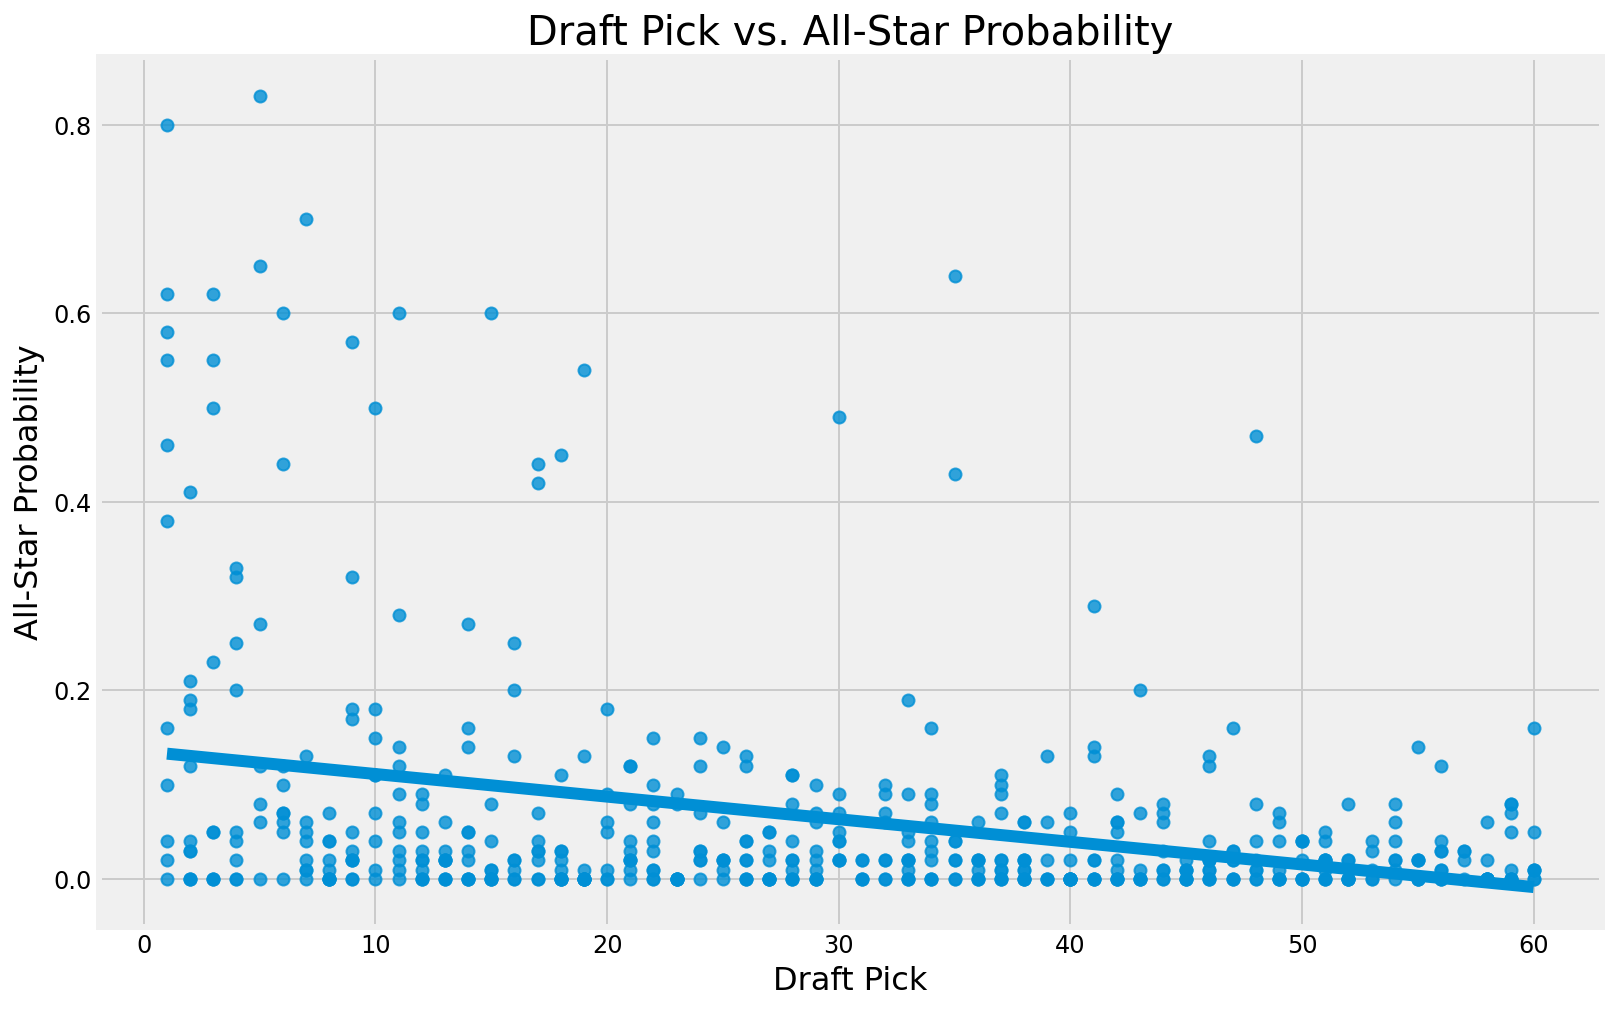

In [68]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'pick', y= 'all_star_prob', data = train_df, ci = None)
plt.xlabel('Draft Pick', size = 16)
plt.ylabel('All-Star Probability', size = 16)
plt.title('Draft Pick vs. All-Star Probability', size = 20)
plt.xticks(size = 12)
plt.yticks(size = 12);



In [69]:
#The graph above shows our models predicted probability vs. draft pick for each player. There is a positive relationship between the probability and the draft pick. The higher the probability of making the All-Star game, the more likely a player will get picked earlier in the draft. This plot makes it easy to spot outliers. One example is Isaiah Thomas who was drafted 60th overall, the last pick in the draft. From our model, Isaiah Thomas had a 16% probability of making an All-Star game in his career which was the highest for anyone at that pick in the last ten years. He did in fact make the All-Star game in 2016, a rare feat for someone drafted where he was.

In [70]:
train_df[(train_df['pick'] == 60) & (train_df['all_star_prob'] > .10)]

,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,ast/tov,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,total_points,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,FT_misses,new_FTM,new_FT_misses,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg,all_star_prob,all_star,player,school,pick
player_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Isaiah Thomas: Washington: 60.0,35,79.1,114.3,27.2,51.7,56.25,2.5,9.5,32.7,19.0,151,210,0.719,128,250,0.512,60,172,0.349,0.2,2.3,49.8,3,69,5.04539,130.894,2.7,2.048092,99.5797,94.9239,3.51267,197.365,6.45543,6.25357,0.201859,7.288,31.8571,5.93,1.358,587,16.77,0,0,0,0,1,0,0,0,1,59,222,90,0.712903,112,96,178,0.349265,122,178,174,0.505714,0.16,1,Isaiah Thomas,Washington,60.0


In [71]:
#test data from 2019
test_df[features].head()

,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,ast/tov,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,total_points,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,FT_misses,new_FTM,new_FT_misses,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg
409,34,79.9,111.9,26.9,57.1,61.08,5.1,11.7,12.2,17.6,108,123,0.878,158,278,0.568,71,185,0.384,0.8,1.7,26.6,4,78,4.82607,128.732,2.5,0.736260,102.5920,97.3832,3.54320,186.847,4.69400,4.99051,-0.296507,5.603,32.8824,5.608,-0.005,637,18.74,0,1,0,0,0,0,0,0,1,15,179,46,0.798206,114,107,180,0.371930,120,208,172,0.547619
427,36,89.3,109.6,23.8,52.8,57.00,4.2,16.0,12.9,16.2,135,181,0.746,125,235,0.532,70,201,0.348,1.6,1.2,41.5,4,80,4.10592,119.545,2.4,0.939020,102.9610,98.1465,3.75634,222.983,3.24698,2.41189,0.835096,4.199,36.1111,3.584,0.615,595,16.53,0,0,1,0,0,0,0,1,0,46,206,77,0.729537,131,106,197,0.348837,110,175,162,0.519403
454,31,95.0,95.5,36.3,45.5,51.53,3.2,22.4,33.0,17.3,193,260,0.742,175,383,0.457,49,163,0.301,1.6,2.2,47.6,4,79,3.48113,112.831,2.3,1.060150,103.3320,103.1590,3.33371,254.358,2.18856,1.20783,0.980732,2.202,38.1563,2.480,-0.278,690,22.26,0,0,0,1,0,0,0,0,1,67,264,98,0.730556,114,85,180,0.319392,208,225,260,0.463768
456,32,84.4,111.6,29.9,54.8,58.67,6.6,23.8,15.4,15.4,122,156,0.782,194,337,0.576,35,113,0.310,3.0,2.4,34.7,4,79,4.03237,120.850,3.2,0.941145,98.3259,97.3771,3.63928,233.284,4.18119,2.11034,2.070840,5.559,33.9394,4.481,1.078,615,19.22,0,0,0,1,0,0,0,1,0,34,193,65,0.750000,78,71,144,0.328638,143,244,195,0.556064
458,32,83.7,126.6,24.7,64.9,68.03,6.8,27.2,13.4,13.6,115,135,0.852,142,215,0.660,97,228,0.425,1.7,2.4,30.5,4,80,5.38479,132.775,2.5,1.217418,94.7661,95.2279,3.85895,266.556,9.48799,7.41188,2.076110,10.432,33.1818,8.873,1.559,690,21.56,0,0,0,1,0,0,0,0,1,20,186,51,0.787234,131,133,197,0.402439,73,192,125,0.606349


In [72]:
#creating a variable to feed into predict function for probabilities
test_proba = test_df[features]


In [73]:
#feeding in test dataframe into fit model for predictions
rf_best.predict(test_proba)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [74]:
#feeding in test dataframe into fit model for probabilities
rf_best.predict_proba(test_proba)[:5]

array([[0.98      , 0.02      ],
       [1.        , 0.        ],
       [0.78171429, 0.21828571],
       [1.        , 0.        ],
       [0.88833333, 0.11166667]])

In [75]:
#creating a variable with each players All-Star probability
all_star_proba = rf_best.predict_proba(test_proba)[:, 1]

In [76]:
all_star_proba[:15]


array([0.02      , 0.        , 0.21828571, 0.        , 0.11166667,
       0.01333333, 0.        , 0.        , 0.1872381 , 0.072     ,
       0.34157143, 0.        , 0.02      , 0.03214286, 0.        ])

In [77]:
#adding probabilities to test dataframe
test_df['all_star_prob'] = np.round(all_star_proba, 2)

In [78]:
#looking at probabilities from greatest to least likelihood
test_df.sort_values(by = 'all_star_prob', ascending = False).head(10)

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,FT_misses,new_FTM,new_FT_misses,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg,all_star_prob
572,Zion Williamson,Duke,33,64.9,129.2,28.2,70.8,70.19,12.8,18.0,15.0,15.2,130,203,0.640,272,364,0.747,24,71,0.338,5.8,3.9,46.7,1,79,6.92564,153.284,2.8,2019,65847,0.871806,1.0,86.7976,81.2443,4.88919,256.0430,17.69180,11.30570,6.386100,17.499,29.9697,12.469,5.030,0,746,22.61,0,0,0,0,0,0,0,1,0,73,201,104,0.660066,47,60,113,0.345029,92,322,144,0.691810,0.56
485,Brandon Clarke,Gonzaga,37,70.2,134.3,24.0,69.3,69.89,13.9,19.7,12.1,12.7,109,157,0.694,253,359,0.705,4,15,0.267,10.8,2.3,42.0,3,80,5.70813,145.016,3.0,2019,43790,1.210581,21.0,83.8970,81.1558,4.60706,276.5900,17.07930,8.23705,8.842300,15.681,28.0811,10.284,5.397,0,627,16.95,0,0,0,1,0,0,0,1,0,48,180,79,0.696498,11,40,77,0.339130,106,303,158,0.657952,0.34
574,Bol Bol,Oregon,9,17.6,116.5,30.4,61.0,63.18,9.7,29.0,9.5,13.5,28,37,0.757,61,107,0.570,13,25,0.520,12.9,1.8,28.0,1,86,4.79844,132.702,2.2,2019,65857,0.500000,44.0,85.3312,82.4436,4.77009,68.8772,10.73770,3.28854,7.449190,12.629,29.8889,8.795,3.834,0,189,21.00,0,0,0,0,0,1,0,0,0,9,99,40,0.715328,12,49,78,0.384000,46,111,98,0.531401,0.29
578,Tyler Herro,Kentucky,37,81.0,118.2,20.0,53.6,58.03,1.6,14.0,15.2,14.8,87,93,0.935,126,234,0.538,60,169,0.355,1.1,2.0,23.1,1,77,4.34548,125.084,1.6,2019,66474,1.533362,13.0,96.8156,90.5414,4.26078,222.6310,7.96711,4.88806,3.079060,8.997,32.6216,5.446,3.551,0,519,14.03,0,0,0,0,0,0,1,0,1,6,158,37,0.813472,109,96,175,0.353160,108,176,160,0.523952,0.23
454,Justin James,Wyoming,31,95.0,95.5,36.3,45.5,51.53,3.2,22.4,33.0,17.3,193,260,0.742,175,383,0.457,49,163,0.301,1.6,2.2,47.6,4,79,3.48113,112.831,2.3,2019,40442,1.060150,40.0,103.3320,103.1590,3.33371,254.3580,2.18856,1.20783,0.980732,2.202,38.1563,2.480,-0.278,0,690,22.26,0,0,0,1,0,0,0,0,1,67,264,98,0.730556,114,85,180,0.319392,208,225,260,0.463768,0.22
544,Jarrett Culver,Texas Tech,38,80.6,106.9,32.2,50.5,54.17,5.7,17.3,25.9,15.5,147,208,0.707,205,390,0.526,49,161,0.304,2.2,2.7,37.7,2,77,4.86583,129.937,2.4,2019,51280,1.368936,6.0,86.1580,81.5243,5.24740,265.9450,10.08400,5.16029,4.923690,10.997,32.4474,6.546,4.451,0,704,18.53,0,1,0,0,0,0,0,0,1,61,218,92,0.704545,112,85,178,0.321839,185,255,237,0.518367,0.21
481,Matisse Thybulle,Washington,36,77.2,103.2,17.2,50.0,54.17,3.0,9.0,13.5,20.5,57,67,0.851,66,119,0.555,46,151,0.305,8.1,6.6,24.8,4,77,1.73851,102.654,3.6,2019,43029,1.166694,20.0,87.4217,84.1684,4.74541,284.5210,11.29060,2.02749,9.263150,9.477,31.0000,1.568,7.909,0,327,9.08,0,0,0,0,0,1,0,0,1,10,128,41,0.760479,105,82,171,0.322709,53,116,105,0.525114,0.19
525,Grant Williams,Tennessee,36,78.6,124.5,27.0,58.3,64.73,8.8,17.4,18.3,15.2,211,258,0.818,215,361,0.596,14,44,0.318,5.3,2.0,63.7,3,79,6.29612,144.172,3.8,2019,49187,1.409683,22.0,96.9792,91.3313,4.04630,248.8940,12.39740,7.91611,4.481270,11.835,31.8919,8.602,3.233,0,683,18.97,0,0,0,0,0,0,1,1,0,47,282,78,0.784916,30,50,96,0.340278,146,265,198,0.572668,0.18
573,R.J. Barrett,Duke,38,87.9,108.0,31.3,50.6,53.19,4.8,17.2,23.5,15.9,149,224,0.665,246,465,0.529,73,237,0.308,1.2,1.4,31.9,1,79,5.55917,132.017,2.1,2019,65854,1.333354,3.0,95.1227,88.8419,4.82899,254.3260,5.59172,4.21776,1.373960,8.011,35.2632,6.425,1.586,0,860,22.63,0,0,0,0,0,0,0,1,0,75,220,106,0.675926,164,109,230,0.320475,219,296,271,0.522124,0.15
510,Carsen Edwards,Purdue,36,87.3,108.0,34.8,49.0,54.09,1.3,10.7,18.3,15.5,185,221,0.837,142,323,0.440,135,380,0.355,1.0,2.3,31.4,3,73,6.20421,137.621,2.3,2019,47325,0.920354,33.0,102.3710,96.3585,3.88820,217.9530,4.92118,5.27258,-0.351396,8.

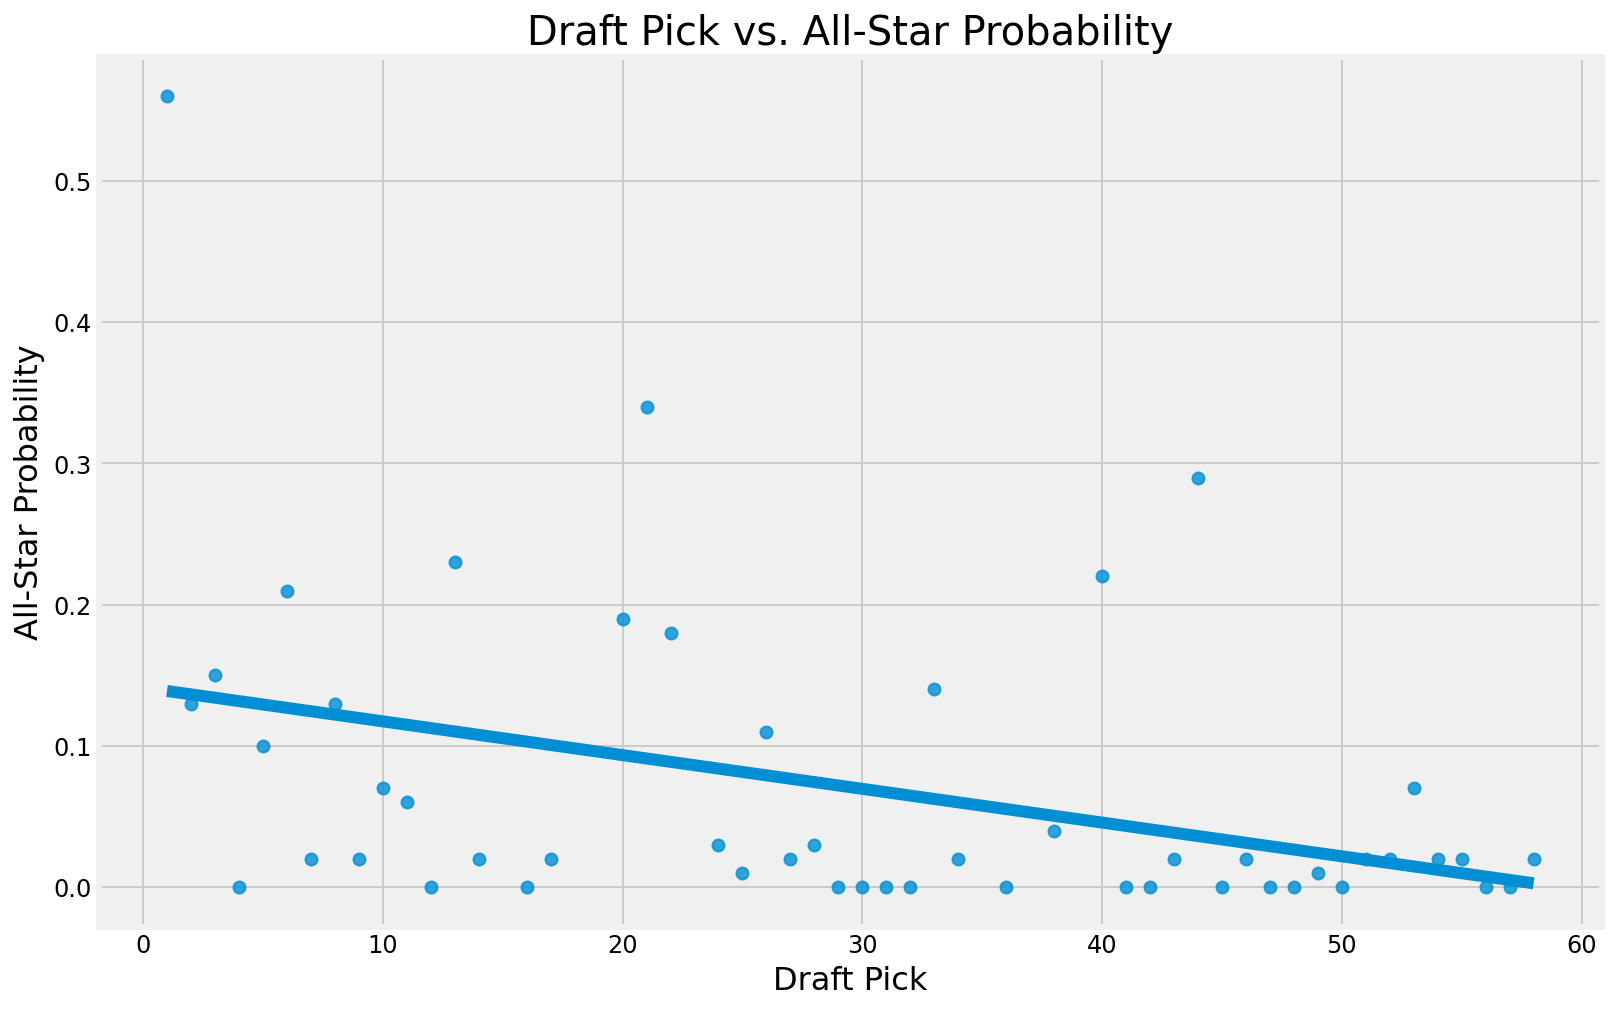

In [79]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'pick', y= 'all_star_prob', data = test_df, ci = None)
plt.xlabel('Draft Pick', size = 16)
plt.ylabel('All-Star Probability', size = 16)
plt.title('Draft Pick vs. All-Star Probability', size = 20)
plt.xticks(size = 12)
plt.yticks(size = 12);

In [80]:
##Based off of our model, Zion Williamson has by far the highest likelihood of becoming an All-Star at some point in his career. Higher draft picks tended to be associated with higher probabilities. This reveals that front offices may have selected well in the 2019 NBA draft. However, Brandon Clarke, had the second highest probability of becoming an All-Star and he was selected 21st overall. Please note that draft position was not included in our model since the goal of this tool is to be used prior to drafting players.

#Additional Modeling
#We are going to reduce the number of features fed into the model and will focus on the RandomForest model which previously predicted the best results and had the most realistic probabilities. We will be using the single season csv file that also contains columns engineered through Bayes statistics.

In [81]:
df2 = pd.read_csv('model_single_season_bayes.csv', index_col = 0)
df2.head()

FileNotFoundError: [Errno 2] No such file or directory: 'model_single_season_bayes.csv'

In [ ]:
#creating testing set dataframe
test_df2 = df2[df2['year'] == 2019]

#removing 2019 from the original dataframe
df2 = df2[df2['year'] != 2019]

#creating new column that will become the index
df2['player_index'] = df2['player_name'] + ': ' + df2['school'] + ': ' + df2['pick'].astype(str)

#setting index
df2.set_index(df2['player_index'], inplace = True)

#dropping newly created columns
df2.drop(columns = ['player_index'], inplace = True)

In [ ]:
df2.head()

In [ ]:
df2.columns

In [ ]:
#features to drop 
drop = ['player_name','school','Min_per','TS_per','FTM','FT_per','twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
        'pfr','year', 'pid','ast/tov', 'pick', 'all_star','stops', 'gbpm', 'ogbpm', 'dbpm', 'obpm','mp','ftr','ht', 'drtg','ORtg',
        'dgbpm', 'total_points', 'FT_misses', 'new_FTM', 'new_FT_misses', '3P_misses', 'new_TPM', 'new_3P_misses',
        '2P_misses', 'new_2PM', 'new_2P_misses']

In [ ]:
features = df2.drop(columns = drop).columns
X2 = df2[features]
y2 = df2['all_star']

In [ ]:
print(X2.shape)
y2.shape

In [ ]:
#train/test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 42, stratify = y2)


In [ ]:
rf2 = RandomForestClassifier(random_state = 42)

rf2_params = {}

rf2_gs = GridSearchCV(rf2, param_grid = rf2_params, cv=3, verbose = 1)
rf2_gs.fit(X2_train, y2_train)

print(f'CrossVal Score: {rf2_gs.best_score_}')
print(f'Training Score: {rf2_gs.score(X2_train, y2_train)}')
print(f'Testing Score: {rf2_gs.score(X2_test, y2_test)}')
print(rf2_gs.best_params_)

In [ ]:
rf2 = RandomForestClassifier(random_state = 42)

rf2_params = {'n_estimators': [50, 60, 70],
             'max_depth': [None, 10, 25, 50],
             'min_samples_split': [2, 3, 4, 5],
             'min_samples_leaf': [1, 2, 3, 4, 5]}

rf2_gs = GridSearchCV(rf2, param_grid=rf2_params, cv=3, verbose = 1)
rf2_gs.fit(X2_train, y2_train)

print('Unscaled')
print(f'CrossVal Score: {rf2_gs.best_score_}')
print(f'Training Score: {rf2_gs.score(X2_train, y2_train)}')
print(f'Testing Score: {rf2_gs.score(X2_test, y2_test)}')
print(rf2_gs.best_params_)

In [ ]:
rf2_gs.predict(X2_test)


In [ ]:
rf2_gs.predict_proba(X2_test)[:10]

In [ ]:
#utilizing best params from RF2 to be able to see most important features
#can't do this on a gridsearched model
rf2_best = RandomForestClassifier(max_depth= None, 
                                 min_samples_leaf= 1, 
                                 min_samples_split= 2,
                                 n_estimators= 60,
                                 random_state= 42)

rf2_best.fit(X2_train, y2_train)

print(f'CrossVal Score: {cross_val_score(rf2_best, X2_train, y2_train)}')
print(f'Training Score: {rf2_best.score(X2_train, y2_train)}')
print(f'Testing Score: {rf2_best.score(X2_test, y2_test)}')

In [ ]:
#creating column in X_train df with the predicted probability
X2_train['all_star_prob'] = rf2_best.predict_proba(X2_train)[:, 1]

#adding target variable back in for evaluation
X2_train['all_star'] = y2_train

#creating column in X_test df with the predicted probability
X2_test['all_star_prob'] = rf2_best.predict_proba(X2_test)[:, 1]

#adding target variable back in for evaluation
X2_test['all_star'] = y2_test

In [ ]:
#Combining dataframes for evaluation
train_df2 = pd.concat([X2_train, X2_test])

#rounding values
train_df2['all_star_prob'] = np.round(train_df2['all_star_prob'], 2)

#adding column for the index
#will be used to split out name, school and draft pick
train_df2['player_index'] = train_df2.index

#creating columns for player name, school and draft pick to be used for evaluation
train_df2[['player', 'school', 'pick']] = train_df2['player_index'].str.split(': ', expand = True)

#dropping player index column
train_df2.drop(columns = ['player_index'], inplace = True)

#adjusting data type of draft pick to be numeric
train_df2['pick'] = train_df2['pick'].astype(float)


In [ ]:
#looking at top 20 most likely players to become an All-Star
train_df2.sort_values(by = 'all_star_prob', ascending = False).head(20)


In [ ]:
#Checking which features had the most importance in the random forest model
rf2_best.feature_importances_

In [ ]:
best_features = pd.DataFrame(rf2_best.feature_importances_.reshape(1,29), columns = features).T
best_features.rename(columns = {0: 'feature_importance'}, inplace = True)
best_features.sort_values(by = 'feature_importance', ascending = False)

In [ ]:
best_features.sort_values(by = 'feature_importance', ascending = False).head(10).plot(kind = 'barh', 
                                                                                      figsize = (12,8),
                                                                                      legend = False,
                                                                                      edgecolor = 'black')
plt.xlabel('Feature Importance', size = 18)
plt.ylabel('Features', size = 18)
plt.title('Most Important Features', size = 22)
plt.xticks(size = 14)
plt.yticks(size = 14);

In [ ]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = 'pick', y= 'all_star_prob', hue = 'all_star', data = train_df2)
plt.xlabel('Draft Pick', size = 18)
plt.ylabel('All-Star Probability', size = 18)
plt.title('Draft Pick vs. All-Star Probability', size = 22)
plt.xticks(size = 14)
plt.yticks(size = 14);

In [ ]:
#creating a column for players with greater than 20%
#seeing if there are similar characteristics between the players
train_df2['> 20%'] = train_df2['all_star_prob'].map(lambda x: 1 if x > .20 else 0)

In [ ]:
train_df2[train_df2['all_star'] == 1].sort_values(by = 'all_star_prob', ascending = False).head()


In [ ]:
#Graphing Top-10 All-Star Probabilities
plt.figure(figsize = (12,8))
# sns.set_palette("Greens", 10)
sns.barplot(y = 'player', x = 'all_star_prob', 
            data = train_df2.sort_values(by = 'all_star_prob', ascending = False)[['player', 'all_star_prob']].head(10),
            orient = 'h',
            edgecolor = 'black')
plt.title("Top 10 All-Star Probabilities", size = 22)
plt.xlabel('All-Star Probability', size = 18)
plt.ylabel("Player", size = 18)
plt.xticks(size = 16)
plt.yticks(size = 16);

In [ ]:
train_df2.groupby('> 20%').mean().T

In [ ]:
Graphically looking at Top Players vs. Average for best features
plt.figure(figsize = (12,12))

#Creating 4 subplots
plt.subplot(2,2,1)

#bar plot of Draymond Green vs. BPM Average
plt.bar('Brandon Clarke' ,train_df2.loc[train_df2['player'] == 'Draymond Green', 'bpm'], edgecolor = 'black')
plt.bar('Average', train_df2['bpm'].mean(), edgecolor = 'black')
plt.title('Draymond Green - BPM', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('BPM', size = 18)

plt.subplot(2,2,2)

#bar plot of Draymond Green vs. PPG Average
plt.bar('Draymond Green' ,train_df2.loc[train_df2['player'] == 'Draymond Green', 'PPG'], edgecolor = 'black')
plt.bar('Average', train_df2['PPG'].mean(), edgecolor = 'black')
plt.title('Draymond Green - PPG', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('PPG', size = 18)


plt.subplot(2,2,3)

#bar plot of Draymond Green vs. DPORPAG Average
plt.bar('Draymond Green' ,train_df2.loc[train_df2['player'] == 'Draymond Green', 'dporpag'], edgecolor = 'black')
plt.bar('Average', train_df2['dporpag'].mean(), edgecolor = 'black')
plt.title('Draymond Green - DPORPAG', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('DPORPAG', size = 18)

plt.subplot(2,2,4)

#bar plot of Draymond Green vs. FTA Average
plt.bar('Draymond Green' ,train_df2.loc[train_df2['player'] == 'Draymond Green', 'FTA'], edgecolor = 'black')
plt.bar('Average', train_df2['FTA'].mean(), edgecolor = 'black')
plt.title('Draymond Green - FTA', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('FTA', size = 18);


In [ ]:
#looking at dataframe of test set
test_df2[features].head()


In [ ]:
#predictions on test set
rf2_best.predict(test_df2[features])

In [ ]:
#probabilities on test set
rf2_best.predict_proba(test_df2[features])[:5]

In [ ]:
#creating variable equal to All-Star probability
all_star_proba2 = rf2_best.predict_proba(test_df2[features])[:, 1]

In [ ]:
#creating column with the probabilities
test_df2['all_star_prob'] = np.round(all_star_proba2, 2)

In [ ]:
#sorting values by all-star probability in descending order
test_df2.sort_values(by = 'all_star_prob', ascending = False).head(10)

In [ ]:
# segregrating df slighlty to view more easily
show_columns = ['player_name', 'school', 'pick' , 'all_star_prob']
test_df2[show_columns].sort_values(by = 'all_star_prob', ascending = False).head()

In [ ]:
#showing players with greater than 5% probability
#5% is the baseline
test_df2[test_df2['all_star_prob'] > .05][show_columns].sort_values(by = 'all_star_prob', ascending = False)

In [ ]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'pick', y= 'all_star_prob', data = test_df2, ci = None)
plt.xlabel('Draft Pick', size = 18)
plt.ylabel('All-Star Probability', size = 18)
plt.title('Draft Pick vs. All-Star Probability', size = 22)
plt.xticks(size = 14)
plt.yticks(size = 14);

In [ ]:
plt.figure(figsize = (12,8))
sns.distplot(test_df2['all_star_prob'],kde = False)
plt.xlabel('All-Star Probability', size = 18)
plt.ylabel('Frequency', size = 18)
plt.title('All-Star Probability Distribution', size = 22)
plt.xticks(size = 14)
plt.yticks(size = 14);

In [ ]:
test_df2['> 5%'] = test_df2['all_star_prob'].map(lambda x: 1 if x > .05 else 0)

In [ ]:
test_df2.drop(columns = drop).groupby('> 5%').mean().T

In [ ]:
#segregating a few of the top features to view more easily
test_df2.drop(columns = drop).groupby('> 5%')[['bpm', 'dporpag', 'FTA', 'adjoe', 'usg', 'PPG']].mean().T

In [ ]:
#taking a look at the highest probilities from the 2019 draft
top_players = ['Zion Williamson', 'Brandon Clarke', 'Ja Morant', 'Bol Bol']

test_df2[test_df2['player_name'].isin(top_players)].sort_values(by = 'all_star_prob', ascending = False)

In [ ]:
#Graphically looking at Top Players vs. Average for best features
plt.figure(figsize = (12,12))

#Creating 4 subplots
plt.subplot(2,2,1)

#bar plot of Zion Williamson vs. BPM Average
plt.bar('Zion Williamson' ,test_df2.loc[test_df2['player_name'] == 'Zion Williamson', 'bpm'], edgecolor = 'black')
plt.bar('Average', test_df2['bpm'].mean(), edgecolor = 'black')
plt.title('Zion Williamson - BPM', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('BPM', size = 18)

plt.subplot(2,2,2)

#bar plot of Zion Williamson vs. PPG Average
plt.bar('Zion Williamson' ,test_df2.loc[test_df2['player_name'] == 'Zion Williamson', 'PPG'], edgecolor = 'black')
plt.bar('Average', test_df2['PPG'].mean(), edgecolor = 'black')
plt.title('Zion Williamson - PPG', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('PPG', size = 18)


plt.subplot(2,2,3)

#bar plot of Zion Williamson vs. DPORPAG Average
plt.bar('Zion Williamson' ,test_df2.loc[test_df2['player_name'] == 'Zion Williamson', 'dporpag'], edgecolor = 'black')
plt.bar('Average', test_df2['dporpag'].mean(), edgecolor = 'black')
plt.title('Zion Williamson - DPORPAG', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('DPORPAG', size = 18)

plt.subplot(2,2,4)

#bar plot of Zion Williamson vs. FTA Average
plt.bar('Zion Williamson' ,test_df2.loc[test_df2['player_name'] == 'Zion Williamson', 'FTA'], edgecolor = 'black')
plt.bar('Average', test_df2['FTA'].mean(), edgecolor = 'black')
plt.title('Zion Williamson - FTA', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('FTA', size = 18);

In [ ]:
#Graphically looking at Top Players vs. Average for best features
plt.figure(figsize = (12,12))

#Creating 4 subplots
plt.subplot(2,2,1)

#bar plot of Brandon Clarke vs. BPM Average
plt.bar('Brandon Clarke' ,test_df2.loc[test_df2['player_name'] == 'Brandon Clarke', 'bpm'], edgecolor = 'black')
plt.bar('Average', test_df2['bpm'].mean(), edgecolor = 'black')
plt.title('Brandon Clarke - BPM', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('BPM', size = 18)

plt.subplot(2,2,2)

#bar plot of Brandon Clarke vs. PPG Average
plt.bar('Brandon Clarke' ,test_df2.loc[test_df2['player_name'] == 'Brandon Clarke', 'PPG'], edgecolor = 'black')
plt.bar('Average', test_df2['PPG'].mean(), edgecolor = 'black')
plt.title('Brandon Clarke - PPG', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('PPG', size = 18)


plt.subplot(2,2,3)

#bar plot of Brandon Clarke vs. DPORPAG Average
plt.bar('Brandon Clarke' ,test_df2.loc[test_df2['player_name'] == 'Brandon Clarke', 'dporpag'], edgecolor = 'black')
plt.bar('Average', test_df2['dporpag'].mean(), edgecolor = 'black')
plt.title('Brandon Clarke - DPORPAG', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('DPORPAG', size = 18)

plt.subplot(2,2,4)

#bar plot of Brandon Clarke vs. FTA Average
plt.bar('Brandon Clarke' ,test_df2.loc[test_df2['player_name'] == 'Brandon Clarke', 'FTA'], edgecolor = 'black')
plt.bar('Average', test_df2['FTA'].mean(), edgecolor = 'black')
plt.title('Brandon Clarke - FTA', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('FTA', size = 18);

In [ ]:
#Graphically looking at Top Players vs. Average for best features
plt.figure(figsize = (12,12))

#Creating 4 subplots
plt.subplot(2,2,1)

#bar plot of Bol Bol vs. BPM Average
plt.bar('Bol Bol' ,test_df2.loc[test_df2['player_name'] == 'Bol Bol', 'bpm'], edgecolor = 'black')
plt.bar('Average', test_df2['bpm'].mean(), edgecolor = 'black')
plt.title('Bol Bol - BPM', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('BPM', size = 18)

plt.subplot(2,2,2)

#bar plot of Bol Bol vs. PPG Average
plt.bar('Bol Bol' ,test_df2.loc[test_df2['player_name'] == 'Bol Bol', 'PPG'], edgecolor = 'black')
plt.bar('Average', test_df2['PPG'].mean(), edgecolor = 'black')
plt.title('Bol Bol - PPG', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('PPG', size = 18)


plt.subplot(2,2,3)

#bar plot of Bol Bol vs. DPORPAG Average
plt.bar('Bol Bol' ,test_df2.loc[test_df2['player_name'] == 'Bol Bol', 'dporpag'], edgecolor = 'black')
plt.bar('Average', test_df2['dporpag'].mean(), edgecolor = 'black')
plt.title('Bol Bol - DPORPAG', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('DPORPAG', size = 18)

plt.subplot(2,2,4)

#bar plot of Bol Bol vs. FTA Average
plt.bar('Bol Bol' ,test_df2.loc[test_df2['player_name'] == 'Bol Bol', 'FTA'], edgecolor = 'black')
plt.bar('Average', test_df2['FTA'].mean(), edgecolor = 'black')
plt.title('Bol Bol - FTA', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.ylabel('FTA', size = 18);

In [ ]:
#From the plot above, you can see that Bol Bol is above average in every category besides FTA. He is well above the average for BPM which was the best feature for our model. His FTA were well below average because he only played in 9 games in college. This is one of the reasons he was drafted in the second round. Teams were concerned with his injury history. If you don't factor in injuries, Bol Bol should have been drafted earlier.

#Conclusions and Recommendations
#Utilizing a random forest model after a train/test split, we were able to predict correctly if a player had become an All-Star at some point in their career 99% of the time and 94% on the test set. The model was slightly overfit and did not perform better than the baseline on the test set. This was not a surprise due to how unbalanced the target class was. However, when looking at the top 20 All-Star probabilities, it predicted the correct value 100% of this time. This even includes players such as Draymond Green who was drafted in the second round and Kyrie Irving who only played 11 games in his college career. Had the front office of a sports team utilized my model, it would have been unlikely that Draymond Green would've been taken at pick 35 in the draft.

#When testing our model on unseen data, the 2019 drafted players, it predicted Zion Williamson to have the highest probability of becoming an All-Star. Zion Williamson was a transcendent player in college this past year and also happened to be the first player taken overall. The player with the second highest probability was Brandon Clarke from Gonzaga. He happened to be selected 21st overall which is not a range where All-Stars are typically taken. We will see soon enough if Brandon Clarke will have a similar career to Draymond Green and surprise the skeptics by becoming an All-Star. He is off to a good start as he was named the MVP of the NBA summer league this year.